# Aumentación de datos con `torchvision`

Si tenemos un dataset de imágenes muy pequeño nuestro modelo podría sobreajustarse. 

Podemos intentar incrementar nuestra dataset usando **transformaciones**. Si rotamos, trasladamos o cambiamos el brillo de una imagen obtendremos una nueva imagen "casi siempre" de la misma clase

`torchvision` tiene funciones implementadas para hacer transformaciones en imágenes

- [Rotación aleatoria](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation)
- [Espejamiento aleatorio](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip)
- [Cropping aleatorio](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomCrop): Recortar la imagen
- [Cambios aleatorios de brillo y contraste](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ColorJitter)
- [Transformación afin aleatoria](https://pytorch.org/docs/stable/torchvision/transforms.html)
- [entre otros](https://pytorch.org/docs/stable/torchvision/transforms.html)

Cada transformación permite especificar límites, por ejemplo "máximo ángulo de rotación", "máxima distorsión de brillo", etc

:::{note}

Las transformaciones también sirven para hacer que la red gane "invarianzas". Por ejemplo, si entrenamos con copias rotadas de nuestras imágenes, la red se volverá invariante a la rotación

:::


:::{important}

Las transformaciones que apliquemos no deben cambiar la interpretación de clase. Ejemplos:

- Si rotas un seis en 180 grados se convierte en un nueve
- Si cambias demasiado el tono (hue) podrías obtener colores distintos a la realidad (¿perro verde?)


:::




In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Transformaciones aleatorias

La mayoría de las transformaciones están diseñadas para aplicarse sobre imágenes en formato PIL

Podemos componer varias transformaciones usando [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html)

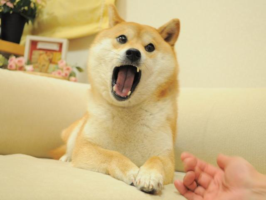

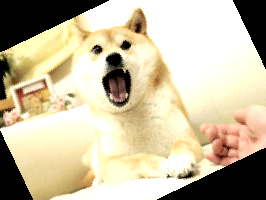

In [2]:
from torchvision import transforms
from PIL import Image

img = Image.open("img/dog.jpg")

my_transform = transforms.Compose([transforms.Resize(200),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(degrees=30),
                                   transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                                          saturation=0.5, hue=0.0),
                                  ])

display(transforms.Resize(200)(img), 
        my_transform(img))

## Entrenando con datos aumentados

Podemos componer una transformación y añadirla a un `Dataset`. Luego cuando usamos el `DataLoader` se generarán imágenes con transformaciones aleatorias de forma automática

:::{important}

¡Sólo se aumenta el conjunto de entrenamiento! Los conjuntos de validación y prueba no deben tener aumentación sintética

:::

A modo de ejemplos aplicaremos una composición de transformaciones al dataset de dígitos manuscritos MNIST. Primero creamos la secuencia de transformaciones para el conjunto de entrenamiento:


In [3]:
mnist_transform = transforms.Compose([transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), 
                                                              scale=(0.5, 1.5), shear=None, 
                                                              interpolation=0, fillcolor=0),
                                      transforms.ColorJitter(brightness=0.5, contrast=0.5, 
                                                             saturation=0.5, hue=0.0),
                                      transforms.ToTensor()
                                     ])

/home/phuijse/.conda/envs/info257/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1428: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/phuijse/.conda/envs/info257/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1435: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  warnings.warn(


Luego cargamos los datos de entrenamiento y le aplicamos la composición utilizando el argumento `transform`

In [4]:
from torchvision.datasets import MNIST

mnist_train_data = MNIST(root='~/datasets', train=True, download=True, 
                         transform=mnist_transform)

Si creamos un dataloader a partir de este dataset entonces se aplicarán las transformaciones de forma aleatoria a cada minibatch

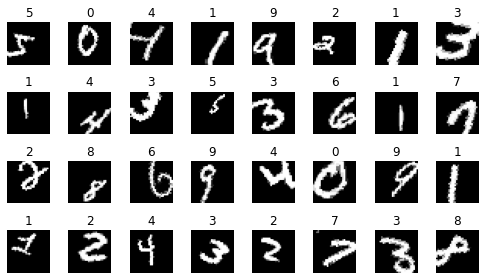

In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(mnist_train_data, shuffle=False, batch_size=32)

for image, label in train_loader:
    break # El primer minibatch

fig, ax = plt.subplots(4, 8, figsize=(7, 4), tight_layout=True)
for k in range(32):
    i, j = np.unravel_index(k, (4, 8))
    ax[i, j].axis('off')
    ax[i, j].set_title(label[k].numpy())
    ax[i, j].imshow(image[k].numpy()[0, :, :], cmap=plt.cm.Greys_r)

Por ejemplo si volvemos a pedir el primer minibatch obtenemos

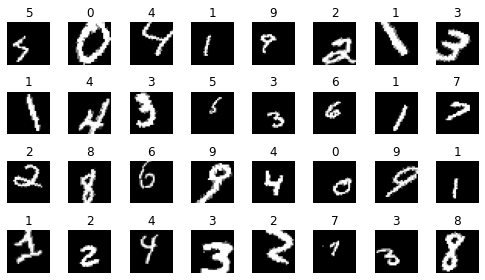

In [6]:
for image, label in train_loader:
    break # El primer minibatch

fig, ax = plt.subplots(4, 8, figsize=(7, 4), tight_layout=True)
for k in range(32):
    i, j = np.unravel_index(k, (4, 8))
    ax[i, j].axis('off')
    ax[i, j].set_title(label[k].numpy())
    ax[i, j].imshow(image[k].numpy()[0, :, :], cmap=plt.cm.Greys_r)

Notar que en este caso `shuffle=False` por lo que los ejemplos originales son los mismos

Sin embargo, las imágenes se ven distintas porque las transformaciones son aleatorias

:::{important}

El dataset de entrenamiento es ligeramente distinto en distintas épocas. Es como si tuvieramos un dataset virtualmente más grande

:::